In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import Perceptron
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler
from sklearn import set_config
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt 
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


This function allows us to create a submission easily

In [2]:
def make_submission():
    submission = titanic_test.copy()
    #display(titanic_test)
    Y_test_pred = model.predict(X_test)
    display(X_test)
    submission['Survived'] = Y_test_pred
    submission.drop(submission.iloc[:, 1:-1], inplace=True, axis=1)
    submission = submission.set_index('PassengerId')
    display(submission)
    submission.to_csv('/kaggle/working/submissionZ.csv')

# Titanic - Machine Learning from Disaster

Is it possible to predict whether someone will survive a given disaster? That is the question we'll try to answer.

Here, we'll be using the example of the Titanic and its passengers. 

## Let's load the data

# Explanations for the columns of our dataset:

**Variable**	Definition	Key
**survival**	Survival	0 = No, 1 = Yes
**pclass**	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
**sex**	Sex	
**Age**	Age in years	
**sibsp**	# of siblings / spouses aboard the Titanic	
**parch**	# of parents / children aboard the Titanic	
**ticket**	Ticket number	
**fare**	Passenger fare	
**cabin**	Cabin number	
**embarked**	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
**Sibling** = brother, sister, stepbrother, stepsister
**Spouse** = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
**Parent** = mother, father
**Child** = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Data Exploration

In [3]:
titanic_train = pd.read_csv('/kaggle/input/titanic/train.csv')
titanic_test = pd.read_csv('/kaggle/input/titanic/test.csv')
print(titanic_train.shape)
display(titanic_train)


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


We can see that there are 11 features and we are trying to predict the survived column. 

Some columns like Age and Cabin seem to cointain NaN values which is a problem. to fill values when it is needed.

The ticket number doesn't give much information since we already have the fare and the cabin. Thus, we can delete this column.
Same goes for the Name column

We'll use one-hot vectors for Sex and Embarked 





Text(0.5, 1.0, 'Survived (binary: yes or no)')

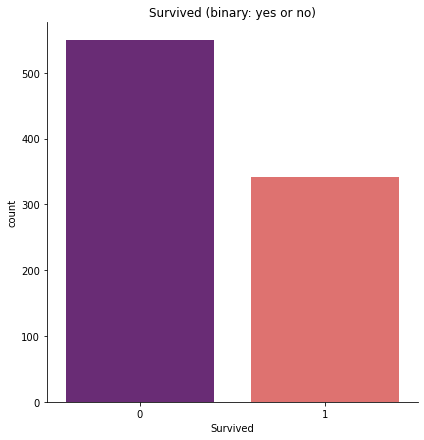

In [4]:
sns.catplot(x="Survived", kind="count",palette="magma", data=titanic_train, height = 6)
plt.title("Survived (binary: yes or no)")

We can see that not everyone died, almost 300 people survived. Thus the classes aren't very imbalanced.

# Data Preparation

We will build a pipeline so that we can clean our data easily.

In [5]:
#constants
features = ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
target = 'Survived'

def pipeline(numerical_imputer, numerical_scaler, numerical_features, categorical_imputer, categorical_encoder, categorical_features, estimator):
    numerical_transformer = Pipeline(
        steps=[
            ("numerical_imputer", numerical_imputer),
            ("numerical_scaler", numerical_scaler),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("categorical_imputer", categorical_imputer),
            ("categorical_encoder", categorical_encoder),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, numerical_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )
    clf = Pipeline( 
        steps=[("preprocessor", preprocessor), ("classifier", estimator)]
    )
    return clf

In [6]:
random_state = 0


numerical_imputer = SimpleImputer(strategy='mean')
numerical_scaler = StandardScaler()
numerical_features = ['Age', 'Fare']
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_encoder = OneHotEncoder(handle_unknown='ignore')
categorical_features = ['Pclass'
            , 'Sex'	
            , 'SibSp'
            , 'Parch'
            , 'Ticket'
            , 'Embarked'
           ]


In [7]:
X_train = titanic_train[numerical_features + categorical_features]
X_test = titanic_test[numerical_features + categorical_features]
y_train = titanic_train[target]

In [8]:
X_train.head()

,Age,Fare,Pclass,Sex,SibSp,Parch,Ticket,Embarked
0,22.0,7.2500,3,male,1,0,A/5 21171,S
1,38.0,71.2833,1,female,1,0,PC 17599,C
2,26.0,7.9250,3,female,0,0,STON/O2. 3101282,S
3,35.0,53.1000,1,female,1,0,113803,S
4,35.0,8.0500,3,male,0,0,373450,S


Our baseline will be the score of a Perceptron algorithm

In [9]:
estimator = Perceptron(random_state = random_state)

In [10]:
model = pipeline(numerical_imputer = numerical_imputer
                 , numerical_scaler = numerical_scaler
                 , numerical_features = numerical_features  
                 , categorical_imputer = categorical_imputer
                 , categorical_encoder = categorical_encoder
                 , categorical_features = categorical_features
                 , estimator = estimator)

In [11]:
set_config(display="diagram")
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('numerical_imputer',
                                                                   SimpleImputer()),
                                                                  ('numerical_scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('categorical_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('categorical_encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'SibSp',
                                                   'Parch', 'Ticket',
                                                   'Embarked'])])),
                ('classifier', Perceptron())])

In [12]:
scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
print("Average CV score:", scores.mean())
print("CV score standard deviation: ", scores.std())


Average CV score: 0.8058426966292135
CV score standard deviation:  0.02883418414803673


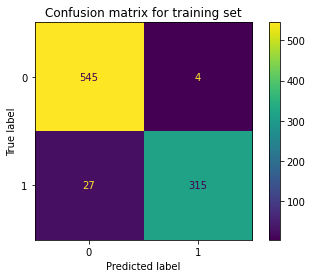

0.9652076318742986


In [13]:
model.fit(X_train, y_train)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, Y_train_pred)
plt.title("Confusion matrix for training set")
plt.show()

print(accuracy_score(y_train, Y_train_pred))

Let's try another model using, XGBoost :

In [14]:
estimator = GradientBoostingClassifier(random_state = random_state)
model = pipeline(numerical_imputer = numerical_imputer
                 , numerical_scaler = numerical_scaler
                 , numerical_features = numerical_features  
                 , categorical_imputer = categorical_imputer
                 , categorical_encoder = categorical_encoder
                 , categorical_features = categorical_features
                 , estimator = estimator)

In [15]:
scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)
print("Average CV score:", scores.mean())
print("CV score standard deviation: ", scores.std())

Average CV score: 0.8148439450686642
CV score standard deviation:  0.036836895821586654


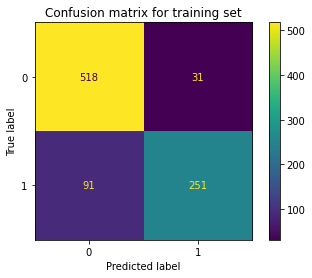

0.8630751964085297


In [16]:
model.fit(X_train, y_train)
Y_train_pred = model.predict(X_train)

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_train, Y_train_pred)
plt.title("Confusion matrix for training set")
plt.show()
print(accuracy_score(y_train, Y_train_pred))

In [17]:
make_submission()

,Age,Fare,Pclass,Sex,SibSp,Parch,Ticket,Embarked
0,34.5,7.8292,3,male,0,0,330911,Q
1,47.0,7.0000,3,female,1,0,363272,S
2,62.0,9.6875,2,male,0,0,240276,Q
3,27.0,8.6625,3,male,0,0,315154,S
4,22.0,12.2875,3,female,1,1,3101298,S
...,...,...,...,...,...,...,...,...
413,NaN,8.0500,3,male,0,0,A.5. 3236,S
414,39.0,108.9000,1,female,0,0,PC 17758,C
415,38.5,7.2500,3,male,0,0,SOTON/O.Q. 3101262,S
416,NaN,8.0500,3,male,0,0,359309,S


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


We can see that there are many missing values for the cabin numbers,we can drop that column.
We can also remove the examples for which there is no age.

In [18]:
"""titanic_train = titanic_train.drop(['Cabin'], axis = 1)

titanic_test = titanic_test.drop(['Cabin'], axis = 1)

#titanic_train = titanic_train.dropna()
#titanic_test = titanic_test.dropna()
titanic_train = titanic_train.fillna(0)
titanic_test = titanic_test.fillna(0)"""

"titanic_train = titanic_train.drop(['Cabin'], axis = 1)\n\ntitanic_test = titanic_test.drop(['Cabin'], axis = 1)\n\n#titanic_train = titanic_train.dropna()\n#titanic_test = titanic_test.dropna()\ntitanic_train = titanic_train.fillna(0)\ntitanic_test = titanic_test.fillna(0)"

### display(titanic_train)
display(titanic_test)